## Imports

In [139]:
from copy import deepcopy

import re
import numpy as np
import pandas as pd

from umap import UMAP

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve

import networkx as nx

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
pd.options.display.max_columns = 100

## Definitions

### plot_confusion_matrix

In [74]:
from itertools import product

import numpy as np

from sklearn.metrics import confusion_matrix
# from ...utils import check_matplotlib_support
# from ...base import is_classifier


class ConfusionMatrixDisplay:
    """Confusion Matrix visualization.

    It is recommend to use :func:`~sklearn.metrics.plot_confusion_matrix` to
    create a :class:`ConfusionMatrixDisplay`. All parameters are stored as
    attributes.

    Read more in the :ref:`User Guide <visualizations>`.

    Parameters
    ----------
    confusion_matrix : ndarray of shape (n_classes, n_classes)
        Confusion matrix.

    display_labels : ndarray of shape (n_classes,)
        Display labels for plot.

    Attributes
    ----------
    im_ : matplotlib AxesImage
        Image representing the confusion matrix.

    text_ : ndarray of shape (n_classes, n_classes), dtype=matplotlib Text, \
            or None
        Array of matplotlib axes. `None` if `include_values` is false.

    ax_ : matplotlib Axes
        Axes with confusion matrix.

    figure_ : matplotlib Figure
        Figure containing the confusion matrix.
    """
    def __init__(self, confusion_matrix, display_labels):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels

    def plot(self, include_values=True, cmap='viridis', labelsize=16,
             xticks_rotation='horizontal',  ticksize=14, ha='center', values_format=None, ax=None):
        """Plot visualization.

        Parameters
        ----------
        include_values : bool, default=True
            Includes values in confusion matrix.

        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.

        xticks_rotation : {'vertical', 'horizontal'} or float, \
                         default='horizontal'
            Rotation of xtick labels.

        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`,
            the format specification is '.2f' for a normalized matrix, and
            'd' for a unnormalized matrix.

        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
        """
        import matplotlib.pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        self.text_ = None

        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(256)

        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)
            if values_format is None:
                values_format = '.2g'

            # print text with appropriate color depending on background
            thresh = (cm.max() - cm.min()) / 2.
            for i, j in product(range(n_classes), range(n_classes)):
                color = cmap_max if cm[i, j] < thresh else cmap_min
                self.text_[i, j] = ax.text(j, i,
                                           format(cm[i, j], values_format),
                                           ha='center', va="center",
                                           color=color)

        fig.colorbar(self.im_, ax=ax, shrink=0.8)
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes))
        
        ax.set_xticklabels(self.display_labels, fontsize=ticksize)
        ax.set_yticklabels(self.display_labels, fontsize=ticksize)
        
        ax.set_ylabel("True label", fontweight='bold', fontsize=labelsize)
        ax.set_xlabel("Predicted label", fontweight='bold', fontsize=labelsize)

        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation, ha=ha)

        self.figure_ = fig
        self.ax_ = ax
        return self


def plot_confusion_matrix(y_true, y_pred, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, labelsize=16,
                          include_values=True,
                          xticks_rotation='horizontal', ticksize=14, ha='center',
                          values_format=None,
                          cmap='viridis', ax=None):
    """Plot Confusion Matrix.

    Read more in the :ref:`User Guide <confusion_matrix>`.

    Parameters
    ----------
    estimator : estimator instance
        Trained classifier.

    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Input values.

    y : array-like of shape (n_samples,)
        Target values.

    labels : array-like of shape (n_classes,), default=None
        List of labels to index the matrix. This may be used to reorder or
        select a subset of labels. If `None` is given, those that appear at
        least once in `y_true` or `y_pred` are used in sorted order.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    normalize : {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.

    display_labels : array-like of shape (n_classes,), default=None
        Target names used for plotting. By default, `labels` will be used if
        it is defined, otherwise the unique labels of `y_true` and `y_pred`
        will be used.

    include_values : bool, default=True
        Includes values in confusion matrix.

    xticks_rotation : {'vertical', 'horizontal'} or float, \
                        default='horizontal'
        Rotation of xtick labels.

    values_format : str, default=None
        Format specification for values in confusion matrix. If `None`,
        the format specification is '.2f' for a normalized matrix, and
        'd' for a unnormalized matrix.

    cmap : str or matplotlib Colormap, default='viridis'
        Colormap recognized by matplotlib.

    ax : matplotlib Axes, default=None
        Axes object to plot on. If `None`, a new figure and axes is
        created.

    Returns
    -------
    display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
    """

    if normalize not in {'true', 'pred', 'all', None}:
        raise ValueError("normalize must be one of {'true', 'pred', "
                         "'all', None}")

    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight,
                          labels=labels)
    if normalize == 'true':
        cm = cm / cm.sum(axis=1, keepdims=True)
    elif normalize == 'pred':
        cm = cm / cm.sum(axis=0, keepdims=True)

    if display_labels is None:
        if labels is None:
            display_labels = np.unique(y_true)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    return disp.plot(include_values=include_values, labelsize=labelsize,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation, ticksize=ticksize, ha=ha)

# Read data

In [9]:
data = pd.read_csv('data/data_clean.csv', index_col='Unnamed: 0')
# data.drop(columns=list(data.columns[data.columns.str.match('style_')]), inplace=True)
# beer_style = pd.read_csv('data/beer_basic_data.csv')['style'].str.replace(' ','')
# data['beer_style'] = beer_style
# data = pd.get_dummies(data,
#               prefix='style',
#               columns=['beer_style'])
# data['beer_style'] = beer_style

method_cols = [col for col in data.columns if re.match('method_', col)]
style_cols = [col for col in data.columns if re.match('style_', col)]
type_cols = [col for col in data.columns if re.match('type_', col)]
cat_cols = list([col for col in data.columns if re.match(r'has_', col) or re.match(r'is_', col)])
con_cols = list([col for col in data.columns 
            if col not in (method_cols + style_cols + type_cols
                           + cat_cols + ['title', 'views', 'reviews', 'rating', 'brewed', 'beer_style'])
           ])
nan_cols = list(data.columns[data.isna().any(0)])
data.head()

,title,final_size,ABV,IBU,OG,FG,color,views,brewed,rating,boil_size,boil_time,boil_grav,pitch_rate,temp_prim,efficiency,mash_thick,reviews,calories,carbs,mash_ph,has_prim_data,has_mash_ph,has_mash_thick,has_pitch_rate,method_AllGrain,method_BIAB,method_Extract,method_PartialMash,d_G_abs,d_G_pct,d_size_abs,d_size_pct,style_under_threshold,style_AmericanAmberAle,style_AmericanBrownAle,style_AmericanIPA,style_AmericanLightLager,style_AmericanPaleAle,style_AmericanStout,style_BlondeAle,style_CreamAle,style_ImperialIPA,style_IrishRedAle,style_Kölsch,style_OatmealStout,style_RobustPorter,style_RussianImperialStout,style_Saison,style_SpecialtyIPA:NewEnglandIPA,style_SweetStout,style_Weissbier,style_Weizen/Weissbier,style_Witbier,beer_style
0,Sierra Nevada Pale Ale Clone,24.605177,5.58,40.12,1.055,1.013,8.00,224412,556,4.79,29.336941,70,1.047,1.00,NaN,79,NaN,25,182,18,5.67,0,1,0,1,1,0,0,0,0.042,0.039810,4.731765,0.161290,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,AmericanPaleAle
1,Avg. Perfect Northeast IPA (NEIPA),21.766118,6.50,50.60,1.062,1.013,5.20,231660,280,4.65,28.390588,60,1.048,NaN,NaN,70,1.25,20,204,19,5.49,1,1,1,0,1,0,0,0,0.049,0.046139,6.624471,0.233333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,SpecialtyIPA:NewEnglandIPA
2,Zombie Dust Clone - ALL GRAIN,22.712471,5.94,54.57,1.061,1.016,8.50,191290,191,4.66,26.497882,60,1.053,NaN,NaN,70,NaN,9,203,22,5.81,0,1,0,0,1,0,0,0,0.045,0.042413,3.785412,0.142857,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,AmericanIPA
3,Zombie Dust Clone - EXTRACT,18.927059,6.16,64.77,1.063,1.016,8.98,176309,155,4.62,22.712471,60,1.052,NaN,NaN,70,NaN,8,208,22,5.41,0,1,0,0,0,0,1,0,0.047,0.044214,3.785412,0.166667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,AmericanIPA
4,Simple Citra IPA - One Gallon,3.785412,6.10,37.06,1.058,1.011,11.45,44521,123,4.79,5.678118,60,1.039,0.35,18.333333,55,1.50,5,190,17,NaN,0,0,1,1,1,0,0,0,0.047,0.044423,1.892706,0.333333,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,AmericanIPA


In [10]:
con_cols

['final_size',
 'ABV',
 'IBU',
 'OG',
 'FG',
 'color',
 'boil_size',
 'boil_time',
 'boil_grav',
 'pitch_rate',
 'temp_prim',
 'efficiency',
 'mash_thick',
 'calories',
 'carbs',
 'mash_ph',
 'd_G_abs',
 'd_G_pct',
 'd_size_abs',
 'd_size_pct']

In [11]:
nan_cols

['boil_grav', 'pitch_rate', 'temp_prim', 'mash_thick', 'mash_ph']

# Predict beer style

## Random Forest

In [34]:
# filters = np.full((len(data),), True)
# filters = (
#     (data.temp_prim.isna() == False) 
#     & (data.mash_thick.isna() == False) 
#     & (data.mash_ph.isna() == False)
#     & (data.pitch_rate.isna() == False)
# )
filters = data.beer_style != 'others'
filters.sum()

6913

In [458]:
set(data[filters].beer_style.value_counts()[:35].index) - set([col.replace('style_', '') for col in style_cols])

set()

In [459]:
style_counts = data[filters].beer_style.value_counts()
style_counts[:15]

AmericanIPA                   1177
AmericanPaleAle                721
BlondeAle                      212
AmericanAmberAle               202
AmericanStout                  143
Witbier                        128
ImperialIPA                    121
OatmealStout                   119
AmericanLightLager             116
IrishRedAle                    115
Weissbier                      113
SweetStout                     112
SpecialtyIPA:NewEnglandIPA     110
CreamAle                       109
Weizen/Weissbier               104
Name: beer_style, dtype: int64

In [460]:
data[filters].beer_type.value_counts()

ipa            1406
apa             721
stout           618
ale             600
wheat           507
lager           396
red             334
dark            299
special_ipa     280
porter          249
fruit           128
sour             69
Name: beer_type, dtype: int64

In [421]:
con_cols

['final_size',
 'ABV',
 'IBU',
 'OG',
 'FG',
 'color',
 'boil_size',
 'boil_time',
 'boil_grav',
 'pitch_rate',
 'temp_prim',
 'efficiency',
 'mash_thick',
 'calories',
 'carbs',
 'mash_ph',
 'beer_type',
 'd_G_abs',
 'd_G_pct',
 'd_size_abs',
 'd_size_pct']

In [128]:
style_cols

['style_under_threshold',
 'style_AmericanAmberAle',
 'style_AmericanBrownAle',
 'style_AmericanIPA',
 'style_AmericanLightLager',
 'style_AmericanPaleAle',
 'style_AmericanStout',
 'style_BlondeAle',
 'style_CreamAle',
 'style_ImperialIPA',
 'style_IrishRedAle',
 'style_Kölsch',
 'style_OatmealStout',
 'style_RobustPorter',
 'style_RussianImperialStout',
 'style_Saison',
 'style_SpecialtyIPA:NewEnglandIPA',
 'style_SweetStout',
 'style_Weissbier',
 'style_Weizen/Weissbier',
 'style_Witbier']

In [198]:
con_features = [
#     'final_size',
    'ABV',
    'IBU',
#     'OG',
#     'FG',
    'color',
#     'boil_size',
#     'boil_time',
#     'boil_grav',
#     'pitch_rate',
    'temp_prim',
#     'efficiency',
#     'mash_thick',
    'calories',
    'carbs',
#     'mash_ph',
#     'd_G_abs',
#     'd_G_pct',
#     'd_size_abs',
#     'd_size_pct'
]
# cat_features = cat_cols
cat_features = []
features = con_features + cat_features
# target = [col for col in style_cols if col != 'style_under_threshold']
target = [
    'style_RussianImperialStout',
    'style_AmericanStout',
    'style_RobustPorter',
    'style_OatmealStout',
    'style_SweetStout',
    'style_AmericanBrownAle',
    'style_IrishRedAle',
    'style_AmericanAmberAle',
    'style_AmericanIPA',
    'style_ImperialIPA',
    'style_SpecialtyIPA:NewEnglandIPA',
    'style_AmericanLightLager',
    'style_AmericanPaleAle',
    'style_BlondeAle',
    'style_CreamAle',
    'style_Kölsch',
    'style_Saison',
    'style_Weissbier',
    'style_Weizen/Weissbier',
    'style_Witbier'
]

filters = (data.beer_style != 'style_under_threshold')
filters = filters & (data[target].sum(axis=1) > 0) & (data[features].isna().any(axis=1) == False)
filters.sum()

2805

In [278]:
[cnt for cnt, style in style_counts]

[835,
 480,
 131,
 126,
 126,
 97,
 89,
 85,
 83,
 82,
 77,
 76,
 73,
 70,
 68,
 68,
 68,
 67,
 55,
 49]

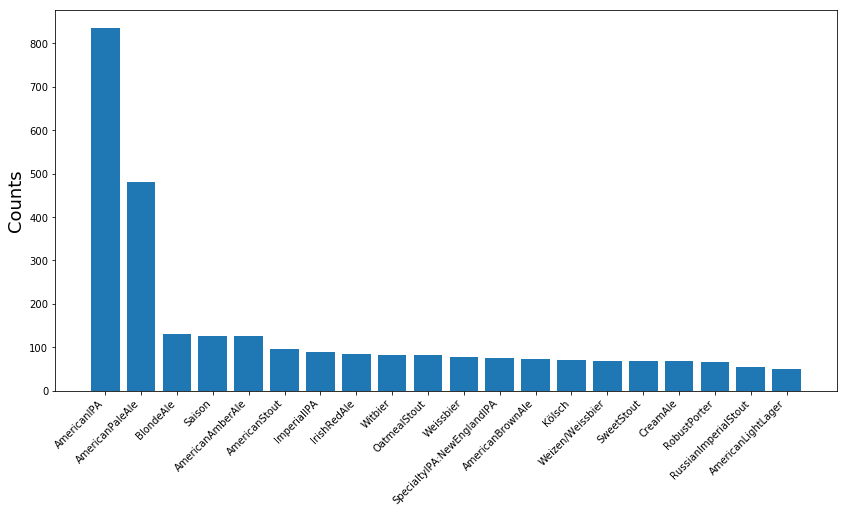

In [285]:
style_counts = sorted(list(zip(data.loc[filters, target].values.sum(0), [s.replace('style_','') for s in target])),
               reverse=True)
plt.figure(figsize=(14,7))
plt.bar(range(len(target)), [cnt for cnt, style in style_counts])
plt.xticks(range(len(target)), [style for cnt, style in style_counts], rotation=45, ha='right')
plt.ylabel('Counts', fontsize=18)
# plt.savefig('fig/style_counts.png')
plt.show()

In [130]:
X = np.zeros(data.loc[filters, features].values.shape)

# scaler = StandardScaler()
# X[:, :len(con_features)] = scaler.fit_transform(data.loc[filters, con_features]) 
X[:, :len(con_features)] = data.loc[filters, con_features].fillna(-99).values 
X[:, len(con_features):] = data.loc[filters, cat_features].fillna(-99).values
y = np.argmax(data.loc[filters, target].values, axis=1)

In [131]:
len(features)

14

In [111]:
max_features = np.arange(1,len(features)+1)
# n_estimators = np.arange(50, 350, 25)
min_samples_leaf = np.maximum(1, np.arange(0, 30, 3))

accuracy_train = np.zeros(shape=(len(max_features), len(min_samples_leaf)))
accuracy_test  = np.zeros(shape=(len(max_features), len(min_samples_leaf)))
best_accuracy = 0
best_scores = np.zeros((y.shape[0], len(target)))
for i, mf in tqdm(enumerate(max_features)):
    for j, msl in enumerate(min_samples_leaf):
        
        model = RandomForestClassifier(n_estimators=100,
                                       max_features=mf,
                                       min_samples_leaf=msl
                                       )

        acc_train = []
        pred = np.zeros(y.shape)
        scores = np.zeros((y.shape[0], len(target)))
        kfold = StratifiedKFold(5, shuffle=True, random_state=42)
        for train_idx, test_idx in kfold.split(X, y):

            model.fit(X[train_idx], y[train_idx])
            acc_train.append((model.predict(X[train_idx]) == y[train_idx]).sum() / len(train_idx))

            pred[test_idx] = model.predict(X[test_idx])
            scores[test_idx, :] = model.predict_proba(X[test_idx])
            
        accuracy_train[i,j] = np.mean(acc_train)
        accuracy_test[i,j] = (pred == y).sum() / y.shape[0]
        if accuracy_test[i,j] > best_accuracy:
            best_accuracy = accuracy_test[i,j]
            best_model = deepcopy(model)
            best_scores = deepcopy(scores)

In [115]:
print('max_features:    ', max_features[np.argmax(accuracy_test) // accuracy_test.shape[1]])
print('Min samples leaf:', min_samples_leaf[np.argmax(accuracy_test) % accuracy_test.shape[1]])
print('accuracy:', np.max(accuracy_test), best_accuracy)

max_features:     6
Min samples leaf: 6
accuracy: 0.5518716577540107 0.5518716577540107


In [116]:
best_model.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

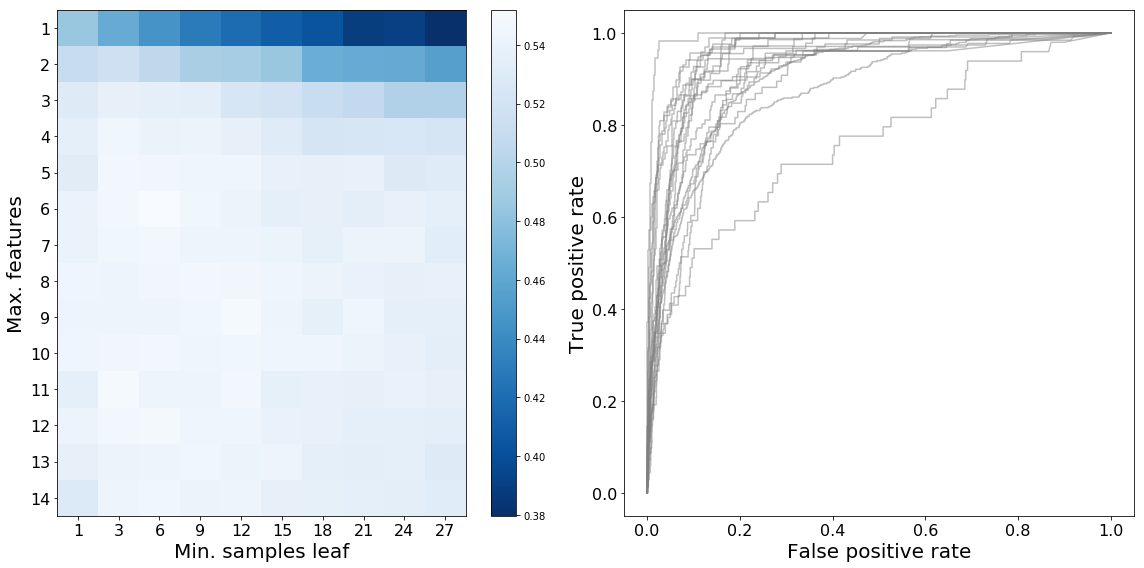

In [117]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

im = ax[0].imshow(accuracy_test, aspect='auto', cmap='Blues_r')
ax[0].set_xticks(np.arange(0,len(min_samples_leaf)))
ax[0].set_xticklabels(min_samples_leaf, fontsize=16)
ax[0].set_yticks(np.arange(0,len(max_features)))
ax[0].set_yticklabels(max_features, fontsize=16)
ax[0].set_xlabel('Min. samples leaf', fontsize=20)
ax[0].set_ylabel('Max. features', fontsize=20)
plt.colorbar(im, ax=ax[0])

for j in range(best_scores.shape[1]):  
    fpr, tpr, thresholds = roc_curve(y, best_scores[:,j], pos_label=j)
    ax[1].plot(fpr, tpr, color='grey', alpha=0.5)
    
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
ax[1].set_xlabel('False positive rate', fontsize=20)
ax[1].set_ylabel('True positive rate', fontsize=20)

fig.tight_layout()

plt.savefig('fig/rf_results.png')
plt.show()

In [118]:
sorted(list(zip(features, best_model.feature_importances_)), key=lambda tup: tup[1], reverse=True)

[('IBU', 0.2846086691549914),
 ('color', 0.27096024399257823),
 ('ABV', 0.1209004556897357),
 ('calories', 0.1045398891426456),
 ('carbs', 0.05256653165619186),
 ('temp_prim', 0.05017040696523071),
 ('d_size_abs', 0.030897389156592382),
 ('boil_size', 0.028312201024404134),
 ('efficiency', 0.02417767879269376),
 ('has_mash_ph', 0.008959552844894698),
 ('boil_time', 0.007482315744132998),
 ('has_mash_thick', 0.007054323724716385),
 ('has_pitch_rate', 0.0053834234771551965),
 ('has_prim_data', 0.003986918634037231)]

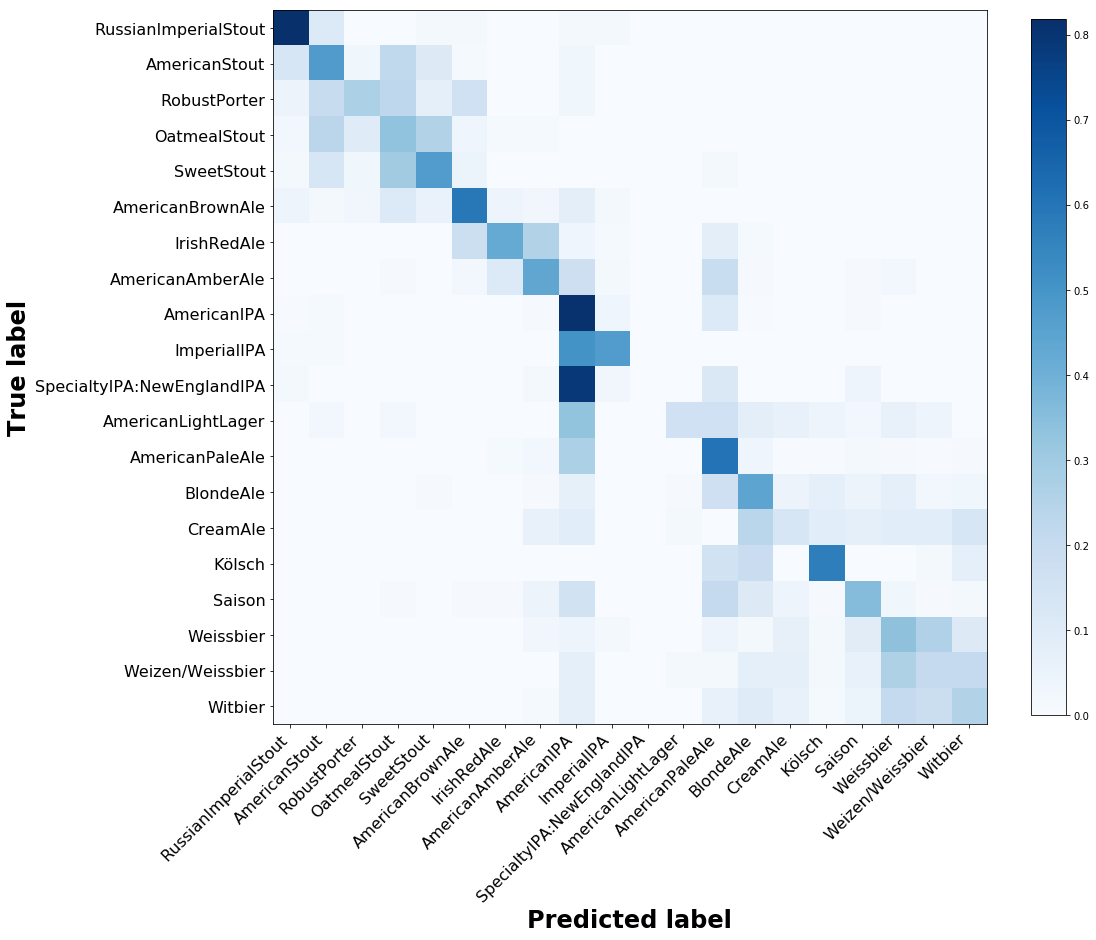

In [133]:
pred = np.zeros(y.shape)
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
for train_idx, test_idx in kfold.split(X, y):

    best_model.fit(X[train_idx], y[train_idx])
    acc_train.append((best_model.predict(X[train_idx]) == y[train_idx]).sum() / len(train_idx))

    pred[test_idx] = best_model.predict(X[test_idx])

fig, ax = plt.subplots(figsize=(16,16))
plot_confusion_matrix(y, pred, normalize='true', 
                      ax=ax, cmap='Blues', 
                      labelsize=24,
                      xticks_rotation=45, ticksize=16, 
                      display_labels=[label.replace('style_','') for label in target], ha='right',
                      values_format='.1f', include_values=False
                     )

# plt.savefig('fig/rf_confusion.png')
plt.show()

## Support Vector Machine

In [134]:
X = np.zeros(data.loc[filters, features].values.shape)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X[:, :len(con_features)] = scaler.fit_transform(data.loc[filters, con_features]) 
# X[:, :len(con_features)] = data.loc[filters, con_features].values 
X[:, len(con_features):] = data.loc[filters, cat_features].values
y = np.argmax(data.loc[filters, target].values, axis=1)

In [98]:
penalty = np.append(np.linspace(1,20,5),
          np.append(np.linspace(40,100,5),
          np.append(np.linspace(200,500,5),
                    np.linspace(600,1000,5))))
# penalty = np.linspace(1, 100, 20)
gamma = np.linspace(0.005, 0.3, 20)

accuracy_train = np.zeros(shape=(len(penalty), len(gamma)))
accuracy_test  = np.zeros(shape=(len(penalty), len(gamma)))
best_accuracy = 0
best_scores = np.zeros((y.shape[0], len(target)))
for i, c in tqdm(enumerate(penalty)):
    for j, g in enumerate(gamma):
        
        model = SVC(kernel='rbf',
                    gamma=g,
                    C=c
                   )

        acc_train = []
        pred = np.zeros(y.shape)
        scores = np.zeros((y.shape[0], len(target)))
        kfold = StratifiedKFold(5, shuffle=True, random_state=42)
        for train_idx, test_idx in kfold.split(X, y):

            model.fit(X[train_idx], y[train_idx])
            acc_train.append((model.predict(X[train_idx]) == y[train_idx]).sum() / len(train_idx))

            pred[test_idx] = model.predict(X[test_idx])
            scores[test_idx, :] = model.decision_function(X[test_idx])
    
        accuracy_train[i,j] = np.mean(acc_train)
        accuracy_test[i,j] = (pred == y).sum() / y.shape[0]
        if accuracy_test[i,j] > best_accuracy:
            best_accuracy = accuracy_test[i,j]
            best_model = deepcopy(model)
            best_scores = deepcopy(scores)

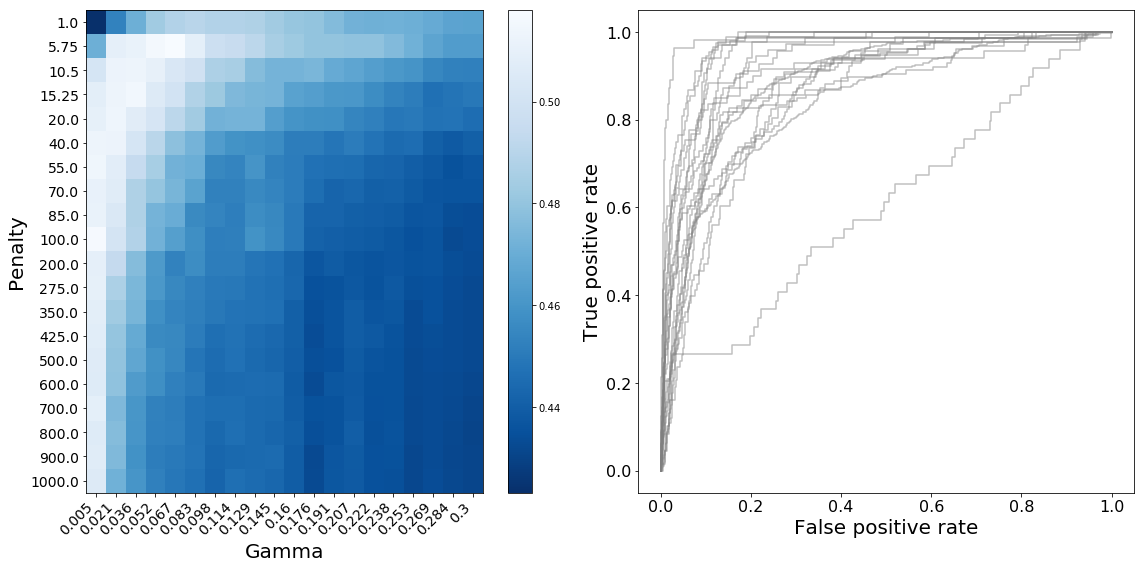

In [104]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

im = ax[0].imshow(accuracy_test, aspect='auto', cmap='Blues_r')
ax[0].set_xticks(np.arange(0,len(gamma)))
ax[0].set_xticklabels(np.round(gamma, 3), rotation=45, ha='right', fontsize=14)
ax[0].set_yticks(np.arange(0,len(penalty)))
ax[0].set_yticklabels(np.round(penalty, 4), fontsize=14)
ax[0].set_xlabel('Gamma', fontsize=20)
ax[0].set_ylabel('Penalty', fontsize=20)
plt.colorbar(im, ax=ax[0])

for j in range(best_scores.shape[1]):  
    fpr, tpr, thresholds = roc_curve(y, best_scores[:,j], pos_label=j)
    ax[1].plot(fpr, tpr, color='grey', alpha=0.5)
    
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
ax[1].set_xlabel('False positive rate', fontsize=20)
ax[1].set_ylabel('True positive rate', fontsize=20)

fig.tight_layout()

plt.savefig('fig/svm_results.png')
plt.show()

In [102]:
print('penalty:', penalty[np.argmax(accuracy_test) // accuracy_test.shape[0]])
print('gamma:  ', gamma[np.argmax(accuracy_test) % accuracy_test.shape[0]])
print('accuracy:', np.max(accuracy_test))

penalty: 5.75
gamma:   0.06710526315789474
accuracy: 0.5180035650623885


In [135]:
best_model = SVC(kernel='rbf', C=5.75, gamma=0.0671)

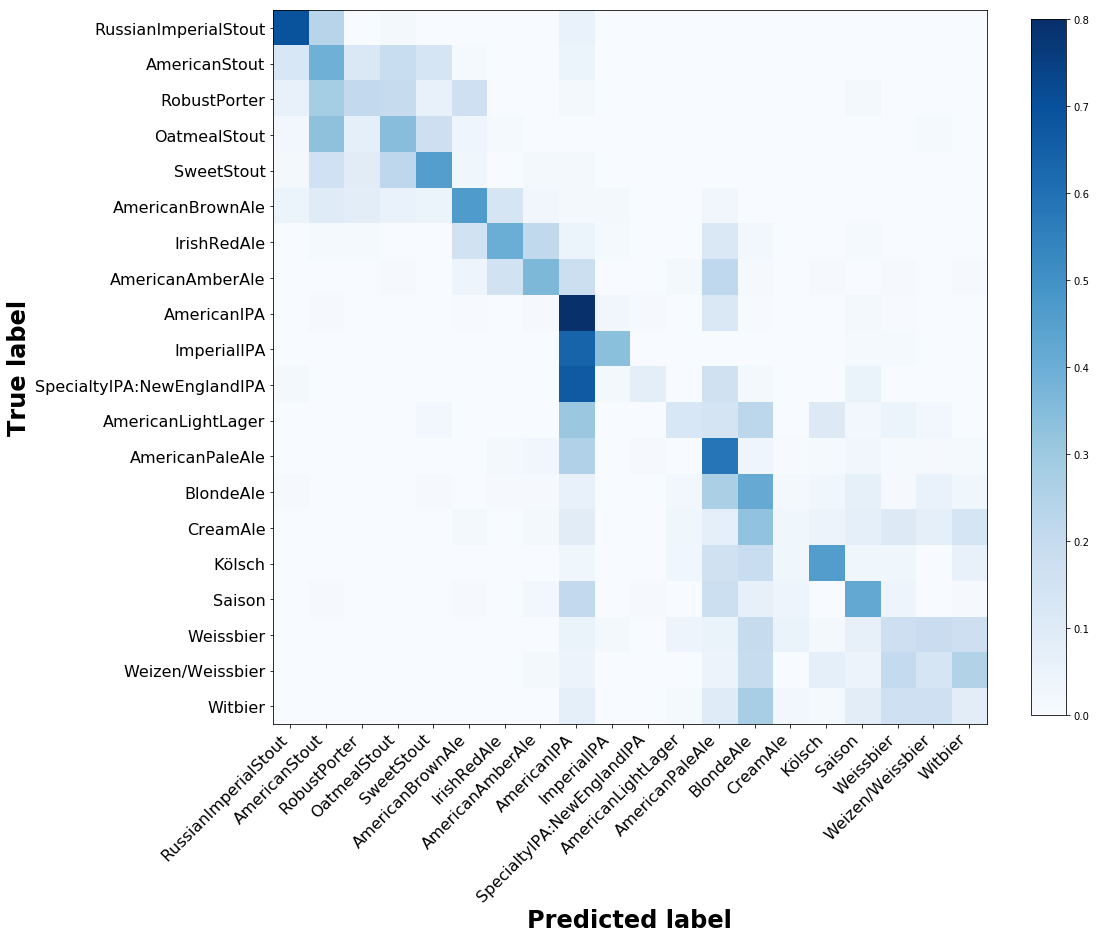

In [136]:
pred = np.zeros(y.shape)
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
for train_idx, test_idx in kfold.split(X, y):

    best_model.fit(X[train_idx], y[train_idx])
    acc_train.append((best_model.predict(X[train_idx]) == y[train_idx]).sum() / len(train_idx))

    pred[test_idx] = best_model.predict(X[test_idx])

fig, ax = plt.subplots(figsize=(16,16))
plot_confusion_matrix(y, pred, normalize='true', 
                      ax=ax, cmap='Blues', 
                      labelsize=24,
                      xticks_rotation=45, ticksize=16, 
                      display_labels=[label.replace('style_','') for label in target], ha='right',
                      values_format='.1f', include_values=False
                     )

plt.savefig('fig/svm_confusion.png')
plt.show()

In [ ]:
target = [
    'style_RussianImperialStout',
    'style_AmericanStout',
    'style_RobustPorter',
    'style_OatmealStout',
    'style_SweetStout',
    'style_AmericanBrownAle',
    'style_IrishRedAle',
    'style_AmericanAmberAle',
    'style_AmericanIPA',
    'style_ImperialIPA',
    'style_SpecialtyIPA:NewEnglandIPA',
    'style_AmericanLightLager',
    'style_AmericanPaleAle',
    'style_BlondeAle',
    'style_CreamAle',
    'style_Kölsch',
    'style_Saison',
    'style_Weissbier',
    'style_Weizen/Weissbier',
    'style_Witbier']

In [177]:
print('penalty:', penalty[np.argmax(accuracy_test) // accuracy_test.shape[0]])
print('gamma:  ', gamma[np.argmax(accuracy_test) % accuracy_test.shape[0]])
print('accuracy:', np.max(accuracy_test))

penalty: 775.25
gamma:   0.015
accuracy: 0.6304044630404463


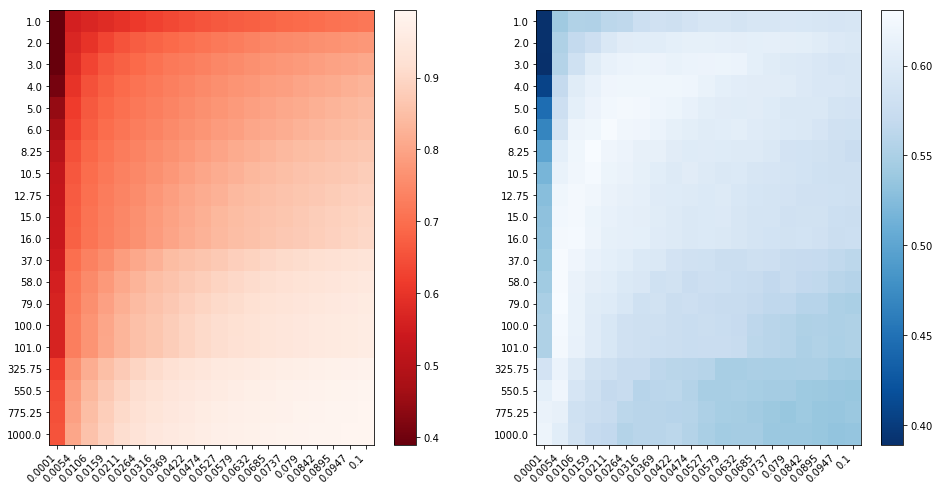

In [171]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

im = ax[0].imshow(accuracy_train, aspect='auto', cmap='Reds_r')
ax[0].set_xticks(np.arange(0,len(gamma)))
ax[0].set_xticklabels(np.round(gamma, 4), rotation=45, ha='right')
ax[0].set_yticks(np.arange(0,len(penalty)))
ax[0].set_yticklabels(np.round(penalty, 4))
plt.colorbar(im, ax=ax[0])

im = ax[1].imshow(accuracy_test, aspect='auto', cmap='Blues_r')
ax[1].set_xticks(np.arange(0,len(gamma)))
ax[1].set_xticklabels(np.round(gamma, 4), rotation=45, ha='right')
ax[1].set_yticks(np.arange(0,len(penalty)))
ax[1].set_yticklabels(np.round(penalty, 4))
plt.colorbar(im, ax=ax[1])

plt.show()

In [170]:
print('penalty:', penalty[np.argmax(accuracy_test) // accuracy_test.shape[0]])
print('gamma:  ', gamma[np.argmax(accuracy_test) % accuracy_test.shape[0]])
print('accuracy:', np.max(accuracy_test))

penalty: 8.25
gamma:   0.015873684210526314
accuracy: 0.6308693630869363


# Unsupervised: find beer style

In [199]:
X = np.zeros(data.loc[filters, features].values.shape)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X[:, :len(con_features)] = scaler.fit_transform(data.loc[filters, con_features]) 
# X[:, :len(con_features)] = data.loc[filters, con_features].values 
X[:, len(con_features):] = data.loc[filters, cat_features].values
# y = np.argmax(data.loc[filters, target].values, axis=1)

## KNN

In [265]:
knn = NearestNeighbors(n_neighbors=3, )
knn.fit(X)

graph = nx.from_scipy_sparse_matrix(knn.kneighbors_graph(X))
connected_comps = list(nx.connected_components(graph))
comp_sizes = []
for comp in connected_comps:
    comp_sizes.append(len(comp))
    
sorted(comp_sizes, reverse=True)

[2745, 9, 8, 5, 5, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3]

In [266]:
groups = pd.DataFrame(index=range(len(connected_comps)), 
                      columns=target)
for i, comp in enumerate(connected_comps):
    groups.loc[i] = (data.loc[filters, target].values[list(comp)].sum(axis=0) 
                     / 
                     data.loc[filters, target].values.sum(axis=0)
                    )
    
sorted(list(zip(groups.values.argmax(axis=0), 
                groups.values.max(axis=0),
                [s.replace('style_','') for s in target])))

[(0, 0.8775510204081632, 'AmericanLightLager'),
 (0, 0.9454545454545454, 'RussianImperialStout'),
 (0, 0.948051948051948, 'Weissbier'),
 (0, 0.9712574850299401, 'AmericanIPA'),
 (0, 0.9736842105263158, 'SpecialtyIPA:NewEnglandIPA'),
 (0, 0.975, 'AmericanPaleAle'),
 (0, 0.9759036144578314, 'Witbier'),
 (0, 0.9841269841269841, 'AmericanAmberAle'),
 (0, 0.9852941176470589, 'CreamAle'),
 (0, 0.9852941176470589, 'Weizen/Weissbier'),
 (0, 0.9857142857142858, 'Kölsch'),
 (0, 0.9920634920634921, 'Saison'),
 (0, 0.9923664122137404, 'BlondeAle'),
 (0, 1.0, 'AmericanBrownAle'),
 (0, 1.0, 'AmericanStout'),
 (0, 1.0, 'ImperialIPA'),
 (0, 1.0, 'IrishRedAle'),
 (0, 1.0, 'OatmealStout'),
 (0, 1.0, 'RobustPorter'),
 (0, 1.0, 'SweetStout')]

## UMAP

In [233]:
n_neighbors=[5, 10, 15, 20, 25, 35, 50, 100, 250]
X_umap = []
for n_neigh in tqdm(n_neighbors):

    reducer = UMAP(n_neighbors=n_neigh, random_state=42)
    X_umap.append(reducer.fit_transform(X))

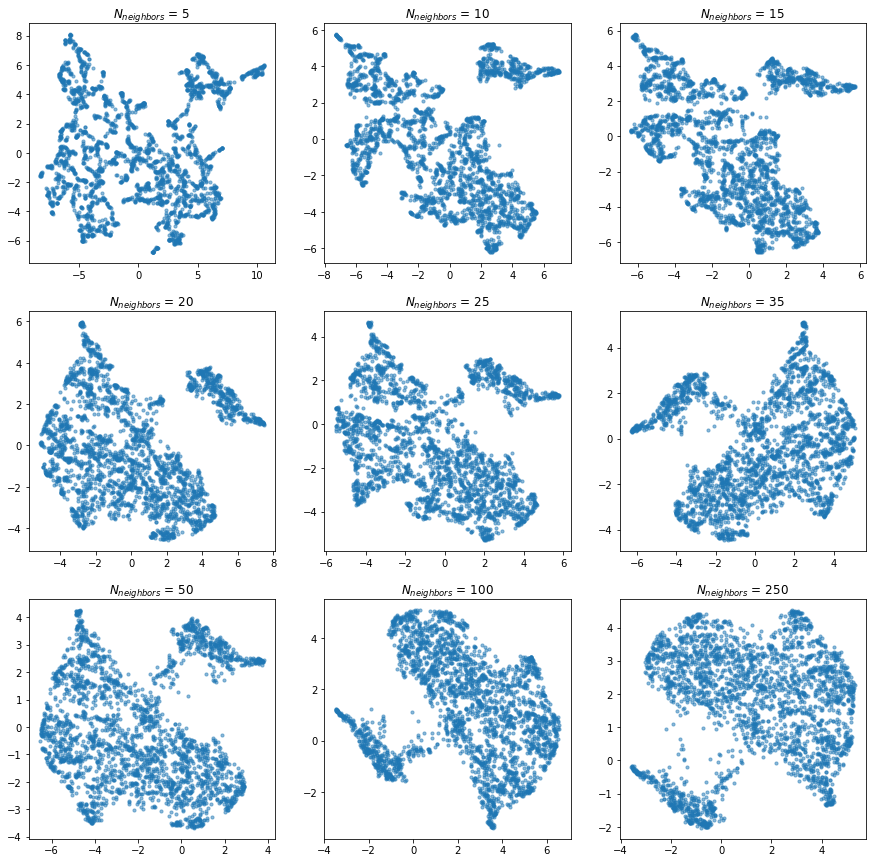

In [234]:
ncols = 3
nrows = np.ceil(len(n_neighbors) / ncols)
fig = plt.figure(figsize=(ncols*5, nrows*5))
for i, n_neigh in enumerate(n_neighbors):

#     reducer = UMAP(n_neighbors=n_neigh)
#     X_umap = reducer.fit_transform(X)

    ax = fig.add_subplot(nrows, ncols, i+1)
    im = ax.scatter(X_umap[i][:,0], X_umap[i][:,1], 
                     alpha=0.5, s=10
                    )
    ax.set_title('$N_{neighbors}$ = ' + str(n_neigh))
    

# plt.savefig('fig/umap_neighbors.png')
plt.show()

In [255]:
idx_umap = 1
knn = NearestNeighbors(n_neighbors=4)
knn.fit(X_umap[idx_umap])

graph = nx.from_scipy_sparse_matrix(knn.kneighbors_graph(X_umap[idx_umap]))
connected_comps = list(nx.connected_components(graph))
comp_sizes = []
for comp in connected_comps:
    comp_sizes.append(len(comp))
    
sorted(comp_sizes, reverse=True)

[575,
 334,
 333,
 284,
 167,
 149,
 104,
 97,
 75,
 74,
 73,
 57,
 50,
 45,
 28,
 28,
 28,
 25,
 24,
 19,
 18,
 17,
 15,
 15,
 14,
 13,
 11,
 11,
 11,
 10,
 9,
 9,
 9,
 9,
 8,
 8,
 7,
 7,
 6,
 6,
 5,
 5,
 5,
 4,
 4]

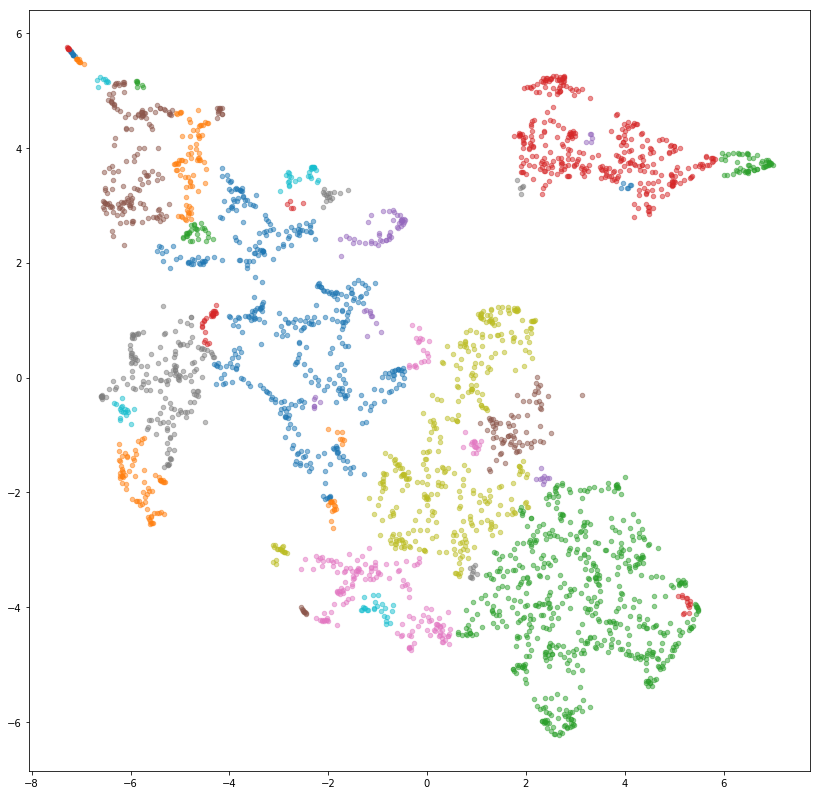

In [258]:
fig, ax = plt.subplots(figsize=(14,14))

for comp in connected_comps:
    ax.scatter(X_umap[idx_umap][list(comp)][:,0], X_umap[idx_umap][list(comp)][:,1], alpha=0.5, s=20)
        
# plt.savefig('fig/umap_knn.png')
plt.show()

In [257]:
groups = pd.DataFrame(index=range(len(connected_comps)), 
                      columns=target)
for i, comp in enumerate(connected_comps):
    groups.loc[i] = (data.loc[filters, target].values[list(comp)].sum(axis=0) 
                     / 
                     data.loc[filters, target].values.sum(axis=0)
                    )
    
sorted(list(zip(groups.values.argmax(axis=0), 
                groups.values.max(axis=0),
                [s.replace('style_','') for s in target])))

[(0, 0.20588235294117646, 'Weizen/Weissbier'),
 (0, 0.22083333333333333, 'AmericanPaleAle'),
 (0, 0.2823529411764706, 'IrishRedAle'),
 (0, 0.3492063492063492, 'AmericanAmberAle'),
 (2, 0.47664670658682634, 'AmericanIPA'),
 (2, 0.4868421052631579, 'SpecialtyIPA:NewEnglandIPA'),
 (2, 0.8089887640449438, 'ImperialIPA'),
 (5, 0.19117647058823528, 'CreamAle'),
 (5, 0.5285714285714286, 'Kölsch'),
 (8, 0.5079365079365079, 'Saison'),
 (11, 0.18072289156626506, 'Witbier'),
 (11, 0.2597402597402597, 'Weissbier'),
 (13, 0.3013698630136986, 'AmericanBrownAle'),
 (13, 0.7761194029850746, 'RobustPorter'),
 (13, 0.845360824742268, 'AmericanStout'),
 (13, 0.8536585365853658, 'OatmealStout'),
 (13, 0.9117647058823529, 'SweetStout'),
 (17, 0.16326530612244897, 'AmericanLightLager'),
 (17, 0.2595419847328244, 'BlondeAle'),
 (32, 0.6545454545454545, 'RussianImperialStout')]